In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
# import socceraction.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
# predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    games = games[games.competition_name == "FIFA World Cup"]
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [15]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    A.append(actions)
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A

Rating actions: 100%|██████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 78.02it/s]


,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,nickname,team_name
0,7525,0bf20e26-a131-4484-9e43-db9ba1cbd1be,1,0.0,799,5196,52.058824,33.569620,75.000000,32.708861,0,1,0,0,pass,success,foot,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia
1,7525,86733aec-904e-4419-8bd3-08765c3436ef,1,1.0,799,5173,75.000000,32.708861,74.117647,33.569620,21,1,0,1,dribble,success,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia
2,7525,ca7bbb49-a2fd-473b-ace3-1ccc4da082ee,1,2.0,799,5173,74.117647,33.569620,26.470588,12.911392,0,0,0,2,pass,fail,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia
3,7525,f37c8329-4e47-4acb-953f-d77d6f4781bd,1,5.0,796,5175,32.647059,10.329114,38.823529,4.303797,0,0,0,3,pass,fail,foot,Ilya Kutepov,None,Russia
4,7525,eedccd29-1635-4d8c-96d9-2d9639ce40a2,1,7.0,799,5178,38.823529,4.303797,25.588235,4.303797,0,1,0,4,pass,success,foot,Salman Mohammed Al Faraj,Salman Al Faraj,Saudi Arabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128932,8658,a6b4c940-fda3-42f8-b4fc-72905aff16c5,2,2978.0,785,5474,22.941176,0.860759,15.882353,2.582278,21,1,0,1719,dribble,success,foot,Ivan Perišić,None,Croatia
128933,8658,d363360b-382d-41ff-b246-139df573edbc,2,2982.0,785,5474,15.882353,2.582278,3.529412,40.455696,1,0,0,1720,cross,fail,foot,Ivan Perišić,None,Croatia
128934,8658,41d8a15c-a3e8-48d6-a18a-d7d7018f79f2,2,2985.0,771,3099,3.529412,40.455696,3.529412,40.455696,15,1,0,1721,keeper_claim,success,foot,Hugo Lloris,None,France
128935,8658,652da4cc-aba6-482f-bc23-d087ada16ece,2,2985.0,771,3099,3.529412,40.455696,15.000000,42.177215,21,1,0,1722,dribble,success,foot,Hugo Lloris,None,France


In [28]:
A["sequence_id"] = ((A["game_id"].diff() != 0) | (A["team_id"].diff() != 0)).astype(int).cumsum()
A

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,nickname,team_name,sequence_id
0,7525,0bf20e26-a131-4484-9e43-db9ba1cbd1be,1,0.0,799,5196,52.058824,33.569620,75.000000,32.708861,...,1,0,0,pass,success,foot,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia,1
1,7525,86733aec-904e-4419-8bd3-08765c3436ef,1,1.0,799,5173,75.000000,32.708861,74.117647,33.569620,...,1,0,1,dribble,success,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,1
2,7525,ca7bbb49-a2fd-473b-ace3-1ccc4da082ee,1,2.0,799,5173,74.117647,33.569620,26.470588,12.911392,...,0,0,2,pass,fail,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,1
3,7525,f37c8329-4e47-4acb-953f-d77d6f4781bd,1,5.0,796,5175,32.647059,10.329114,38.823529,4.303797,...,0,0,3,pass,fail,foot,Ilya Kutepov,None,Russia,2
4,7525,eedccd29-1635-4d8c-96d9-2d9639ce40a2,1,7.0,799,5178,38.823529,4.303797,25.588235,4.303797,...,1,0,4,pass,success,foot,Salman Mohammed Al Faraj,Salman Al Faraj,Saudi Arabia,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128932,8658,a6b4c940-fda3-42f8-b4fc-72905aff16c5,2,2978.0,785,5474,22.941176,0.860759,15.882353,2.582278,...,1,0,1719,dribble,success,foot,Ivan Perišić,None,Croatia,21876
128933,8658,d363360b-382d-41ff-b246-139df573edbc,2,2982.0,785,5474,15.882353,2.582278,3.529412,40.455696,...,0,0,1720,cross,fail,foot,Ivan Perišić,None,Croatia,21876
128934,8658,41d8a15c-a3e8-48d6-a18a-d7d7018f79f2,2,2985.0,771,3099,3.529412,40.455696,3.529412,40.455696,...,1,0,1721,keeper_claim,success,foot,Hugo Lloris,None,France,21877
128935,8658,652da4cc-aba6-482f-bc23-d087ada16ece,2,2985.0,771,3099,3.529412,40.455696,15.000000,42.177215,...,1,0,1722,dribble,success,foot,Hugo Lloris,None,France,21877


In [ ]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

In [11]:
A.reset_index(inplace=True)
A["index"] = A["index"] + 1
A.to_csv("../data/action-values.csv", index=False, encoding="utf-8-sig")

## Analyse VAEP ratings

In [13]:
A = pd.read_csv("../data/action-arrows.csv", header=0, encoding="utf-8-sig")
A

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,status,x,y,...,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
0,0,7525,0bf20e26-a131-4484-9e43-db9ba1cbd1be,1,0.0,799,5196,start,52.058824,33.569620,...,foot,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia,0.001732,0.001125,0.000000,-0.000000,0.000000,1
1,1,7525,0bf20e26-a131-4484-9e43-db9ba1cbd1be,1,0.0,799,5196,end,75.000000,32.708861,...,foot,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia,0.001732,0.001125,0.000000,-0.000000,0.000000,1
2,2,7525,86733aec-904e-4419-8bd3-08765c3436ef,1,1.0,799,5173,start,75.000000,32.708861,...,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.003139,0.001326,0.001408,-0.000201,0.001206,1
3,3,7525,86733aec-904e-4419-8bd3-08765c3436ef,1,1.0,799,5173,end,74.117647,33.569620,...,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.003139,0.001326,0.001408,-0.000201,0.001206,1
4,4,7525,ca7bbb49-a2fd-473b-ace3-1ccc4da082ee,1,2.0,799,5173,start,74.117647,33.569620,...,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.002697,0.001956,-0.000443,-0.000630,-0.001072,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257869,257869,8658,41d8a15c-a3e8-48d6-a18a-d7d7018f79f2,2,2985.0,771,3099,end,3.529412,40.455696,...,foot,Hugo Lloris,NaN,France,0.004177,0.007640,-0.003417,0.001711,-0.001706,1
257870,257870,8658,652da4cc-aba6-482f-bc23-d087ada16ece,2,2985.0,771,3099,start,3.529412,40.455696,...,foot,Hugo Lloris,NaN,France,0.005812,0.002726,0.001635,0.004914,0.006549,1
257871,257871,8658,652da4cc-aba6-482f-bc23-d087ada16ece,2,2985.0,771,3099,end,15.000000,42.177215,...,foot,Hugo Lloris,NaN,France,0.005812,0.002726,0.001635,0.004914,0.006549,1
257872,257872,8658,4a74b841-e3a7-4032-bd81-bc2f4545e50f,2,3001.0,771,3099,start,15.000000,42.177215,...,foot,Hugo Lloris,NaN,France,0.011213,0.001173,0.011213,-0.001173,0.010041,1


In [28]:
cols = A.columns[1:7].tolist() + ['status', 'x', 'y'] + A.columns[11:].tolist()

In [27]:
action_starts = A.copy()
action_starts['status'] = 'start'
action_starts = action_starts.rename(columns={'start_x': 'x', 'start_y': 'y'})[cols]

action_ends = A.copy()
action_ends['status'] = 'end'
action_ends = action_ends.rename(columns={'end_x': 'x', 'end_y': 'y'})[cols]

actions = pd.concat([action_starts, action_ends]).sort_values(['game_id', 'action_id'], ignore_index=True).reset_index()
actions.to_csv("../data/action-points.csv", index=True, encoding="utf-8-sig")

### Most valuable players

In [15]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
stats = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby("player_id").sum().reset_index()
)

# Add player and team names
stats = stats.merge(players[["player_id", "nickname", "player_name"]], how="left")
stats["team_name"] = A.groupby("player_id")[["team_name"]].first().reset_index(drop=True)
stats["player_name"] = stats[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)

# Show results
stats = stats[["player_id", "team_name", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
stats = stats.sort_values("vaep_value", ascending=False, ignore_index=True)
stats[:20]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
0,3009,France,Kylian Mbappé,3.335042,3.432357,-0.097315,495
1,5186,Russia,Denis Cheryshev,2.884800,3.285939,-0.401139,214
2,3089,Belgium,Kevin De Bruyne,2.869285,2.965952,-0.096667,716
3,20004,France,Paul Pogba,2.866437,2.761893,0.104544,676
4,5574,Germany,Toni Kroos,2.746799,2.802115,-0.055316,646
5,3621,Belgium,Eden Hazard,2.674756,2.774973,-0.100218,691
6,4319,Uruguay,Edinson Cavani,2.633588,2.618300,0.015288,226
7,3244,England,John Stones,2.601864,2.561304,0.040561,937
8,3501,Brazil,Philippe Coutinho,2.593071,2.551080,0.041991,703
9,3308,England,Kieran Trippier,2.577730,3.475827,-0.898097,690


In [16]:
stats.sort_values("defensive_value", ascending=False)[:10]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
71,5528,Peru,Pedro Gallese,0.938272,0.232608,0.705664,119
43,3509,Belgium,Thibaut Courtois,1.108530,0.423728,0.684802,364
111,3101,Belgium,Vincent Kompany,0.669809,0.104889,0.564920,542
85,3444,Croatia,Danijel Subašić,0.855281,0.329523,0.525758,321
73,5622,Sweden,Robin Olsen,0.907231,0.383787,0.523444,176
90,5504,Argentina,Éver Banega,0.809302,0.302768,0.506533,440
97,5267,Uruguay,Fernando Muslera,0.738031,0.299578,0.438453,194
129,5619,South Korea,Cho Hyun-Woo,0.588475,0.176767,0.411707,121
105,5597,Costa Rica,Keylor Navas,0.707204,0.311354,0.395850,138
128,3240,Australia,Mat Ryan,0.594473,0.206228,0.388245,202


In [17]:
stats[stats.team_name == "South Korea"]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
24,3083,South Korea,Son Heung-Min,1.539923,1.685215,-0.145292,229
33,5604,South Korea,Kim Young-Gwon,1.339252,1.280336,0.058915,181
129,5619,South Korea,Cho Hyun-Woo,0.588475,0.176767,0.411707,121
205,5618,South Korea,Jung Woo-Young,0.315286,0.343271,-0.027985,138
245,5608,South Korea,Lee Yong,0.225842,0.293330,-0.067488,236
298,5986,South Korea,Hong Chul,0.137045,0.124260,0.012784,74
309,5988,South Korea,Ju Se-Jong,0.119194,0.152508,-0.033314,88
311,3605,South Korea,Ki Sung-Yeung,0.118675,0.102121,0.016555,171
365,6323,South Korea,Yun Young-Sun,0.032769,0.005961,0.026808,25
379,6325,South Korea,Ko Yo-Han,0.014980,0.012887,0.002094,11


In [18]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats_normal = stats.merge(mp)
stats_normal = stats_normal[stats_normal.minutes_played > 180] # at least two full games played
stats_normal["vaep_rating"] = stats_normal.vaep_value * 90 / stats_normal.minutes_played
stats_normal["offensive_rating"] = stats_normal.offensive_value * 90 / stats_normal.minutes_played
stats_normal["defensive_rating"] = stats_normal.defensive_value * 90 / stats_normal.minutes_played
stats_normal.sort_values("vaep_rating", ascending=False)[:10]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
4,5574,Germany,Toni Kroos,2.746799,2.802115,-0.055316,646,289,0.855405,0.872631,-0.017226
1,5186,Russia,Denis Cheryshev,2.884800,3.285939,-0.401139,214,312,0.832154,0.947867,-0.115713
17,5674,Senegal,Moussa Wagué,1.717616,1.685831,0.031785,168,208,0.743199,0.729446,0.013753
16,5473,Nigeria,Ahmed Musa,1.774202,1.787184,-0.012982,162,220,0.725810,0.731121,-0.005311
11,6196,Colombia,Yerry Mina,2.425029,2.295718,0.129312,325,315,0.692866,0.655919,0.036946
6,4319,Uruguay,Edinson Cavani,2.633588,2.618300,0.015288,226,355,0.667670,0.663794,0.003876
37,5578,Germany,Jérôme Boateng,1.241695,1.259150,-0.017455,374,190,0.588171,0.596439,-0.008268
15,5692,Colombia,Juan Fernando Quintero,1.889488,1.987896,-0.098408,374,309,0.550336,0.578999,-0.028663
0,3009,France,Kylian Mbappé,3.335042,3.432357,-0.097315,495,550,0.545734,0.561658,-0.015924
8,3501,Brazil,Philippe Coutinho,2.593071,2.551080,0.041991,703,453,0.515180,0.506837,0.008343


### (optional) Most valuable players per action type

In [19]:
A.type_name.unique()

array(['pass', 'dribble', 'tackle', 'throw_in', 'interception', 'foul',
       'cross', 'clearance', 'bad_touch', 'shot', 'goalkick',
       'keeper_save'], dtype=object)

In [20]:
type_merger = {
    "take_on": "dribble",
    "corner_short": "pass", "freekick_short": "pass",
    "corner_crossed": "cross", "freekick_crossed": "cross",
    "keeper_claim": "keeper_save", "keeper_punch": "keeper_save",
    "shot_freekick": "shot", "shot_penalty": "shot"
}
A["type_name"] = A["type_name"].replace(type_merger)
A.type_name.unique()

array(['pass', 'dribble', 'tackle', 'throw_in', 'interception', 'foul',
       'cross', 'clearance', 'bad_touch', 'shot', 'goalkick',
       'keeper_save'], dtype=object)

In [21]:
# Compute each player's number of actions and total VAEP values
stats_split = (
    A[["player_id", "type_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id", "type_name"]).sum().reset_index()
)

# Add player and team names
stats_split = stats_split.merge(players[["player_id", "nickname", "player_name"]], how="left")
stats_split["team_name"] = A.groupby(["player_id", "type_name"])[["team_name"]].first().reset_index(drop=True)
stats_split["player_name"] = stats_split[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)

# Show results
stats_split = stats_split[stats_split["vaep_value"] > 0.2]
stats_split = stats_split[["player_id", "team_name", "player_name", "type_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
stats_split = stats_split.sort_values("vaep_value", ascending=False, ignore_index=True)
stats_split[:20]

,player_id,team_name,player_name,type_name,vaep_value,offensive_value,defensive_value,count
0,5186,Russia,Denis Cheryshev,shot,2.746740,3.142415,-0.395675,14
1,4320,Brazil,Neymar,dribble,2.505584,2.457478,0.048106,404
2,3009,France,Kylian Mbappé,shot,2.348812,2.356900,-0.008088,8
3,6196,Colombia,Yerry Mina,shot,2.004542,2.004025,0.000517,3
4,4319,Uruguay,Edinson Cavani,shot,1.931352,1.948103,-0.016751,16
5,3621,Belgium,Eden Hazard,dribble,1.854636,1.826173,0.028463,374
6,5207,Portugal,Cristiano Ronaldo,shot,1.747733,1.867820,-0.120087,22
7,3289,Belgium,Romelu Lukaku,shot,1.665397,1.680487,-0.015090,14
8,4320,Brazil,Neymar,cross,1.657561,1.717450,-0.059890,41
9,5203,Spain,Sergio Busquets,pass,1.600825,1.594157,0.006668,311


In [22]:
stats_renamed = stats[["player_id", "team_name", "player_name", "vaep_value"]].rename(columns={"vaep_value": "vaep_total"})
stats_split = stats_renamed.merge(stats_split)
stats_split[:40]

,player_id,team_name,player_name,vaep_total,type_name,vaep_value,offensive_value,defensive_value,count
0,3009,France,Kylian Mbappé,3.335042,shot,2.348812,2.356900,-0.008088,8
1,3009,France,Kylian Mbappé,3.335042,dribble,1.286661,1.259931,0.026730,289
2,3009,France,Kylian Mbappé,3.335042,cross,0.293006,0.314497,-0.021491,14
3,5186,Russia,Denis Cheryshev,2.884800,shot,2.746740,3.142415,-0.395675,14
4,5186,Russia,Denis Cheryshev,2.884800,dribble,0.370084,0.351987,0.018097,86
5,3089,Belgium,Kevin De Bruyne,2.869285,dribble,0.952563,0.899826,0.052737,323
6,3089,Belgium,Kevin De Bruyne,2.869285,cross,0.875646,0.922500,-0.046854,30
7,3089,Belgium,Kevin De Bruyne,2.869285,shot,0.556985,0.577005,-0.020020,12
8,3089,Belgium,Kevin De Bruyne,2.869285,pass,0.539042,0.607612,-0.068569,315
9,20004,France,Paul Pogba,2.866437,pass,1.202196,1.156888,0.045309,299


In [32]:
type_names = ["pass"]

# Compute each player's number of actions and total VAEP values
A_action = A[A.type_name.isin(type_names)]
stats_action = (
    A_action[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby("player_id").sum().reset_index()
)

# Add player and team names
stats_action = stats_action.merge(players[["player_id", "nickname", "player_name"]], how="left")
stats_action["team_name"] = A_action.groupby("player_id")[["team_name"]].first().reset_index(drop=True)
stats_action["player_name"] = stats_action[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)

# Show results
stats_action = stats_action[["player_id", "team_name", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
stats_action = stats_action.sort_values("vaep_value", ascending=False, ignore_index=True)
stats_action[:20]

,player_id,team_name,player_name,vaep_value,offensive_value,defensive_value,count
0,5203,Spain,Sergio Busquets,1.600825,1.594157,0.006668,311
1,5574,Germany,Toni Kroos,1.301838,1.271616,0.030222,304
2,3336,England,Harry Maguire,1.280909,1.162219,0.118690,426
3,20004,France,Paul Pogba,1.202196,1.156888,0.045309,299
4,5470,Croatia,Ivan Rakitić,1.125797,1.070837,0.054960,404
5,5201,Spain,Sergio Ramos,1.119048,0.960911,0.158137,493
6,3532,England,Jordan Henderson,1.039096,0.978290,0.060806,297
7,3205,England,Kyle Walker,0.945963,0.858860,0.087102,379
8,5485,France,Raphaël Varane,0.873007,0.695517,0.177489,335
9,3176,Belgium,Thomas Meunier,0.847579,0.825138,0.022442,195


### (optional) Inspect a Team's top 10 most valuable non-shot actions

2018-06-23 17:00:00 South Korea 1-2 Mexico 92' shot Heung-Min Son


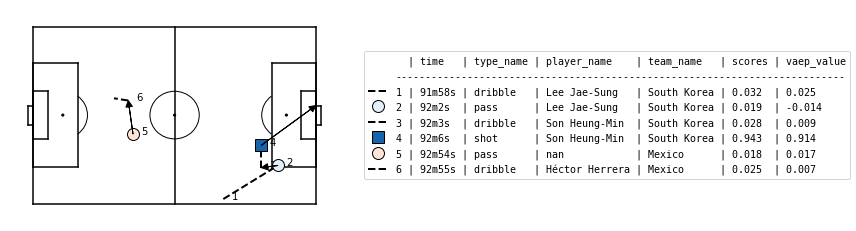

2018-06-27 16:00:00 South Korea 2-0 Germany 95' shot Heung-Min Son


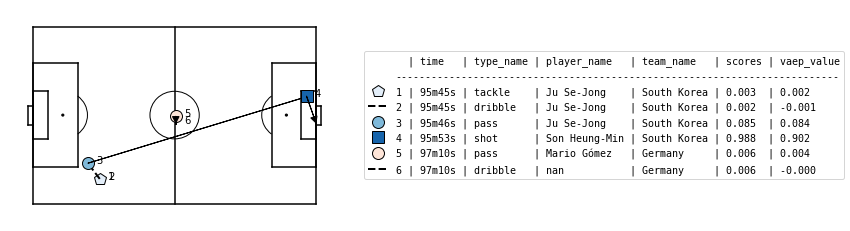

2018-06-27 16:00:00 South Korea 2-0 Germany 91' shot Young-Gwon Kim


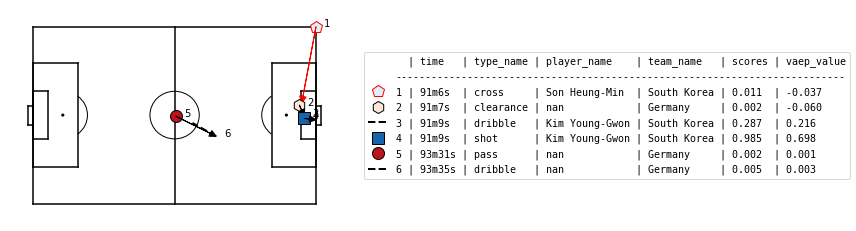

2018-06-27 16:00:00 South Korea 2-0 Germany 91' dribble Young-Gwon Kim


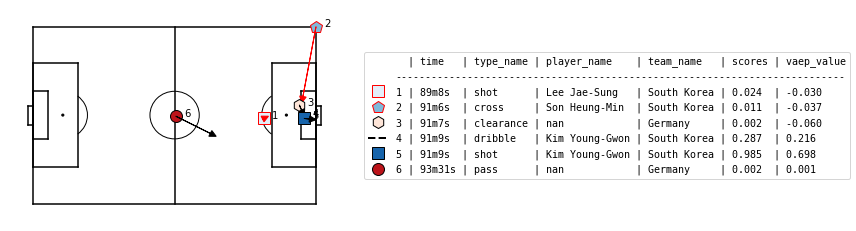

2018-06-18 14:00:00 Sweden 1-0 South Korea 73' dribble Hyeon-Woo Jo


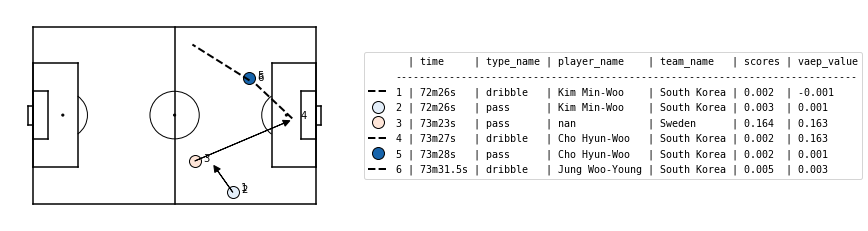

2018-06-18 14:00:00 Sweden 1-0 South Korea 5' cross Heung-Min Son


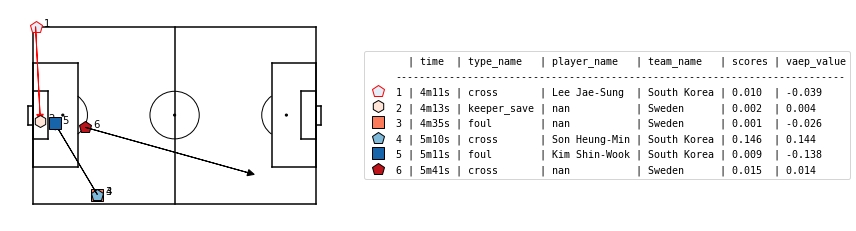

2018-06-18 14:00:00 Sweden 1-0 South Korea 55' dribble Young-Gwon Kim


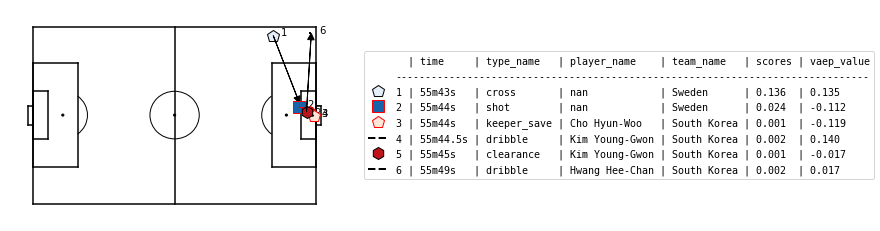

2018-06-23 17:00:00 South Korea 1-2 Mexico 74' pass Hee-Chan Hwang


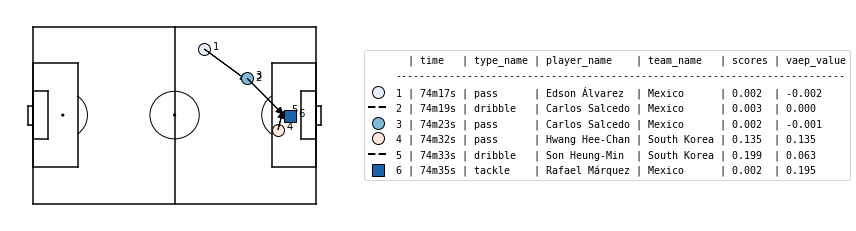

2018-06-18 14:00:00 Sweden 1-0 South Korea 31' cross Hyun-Soo Jang


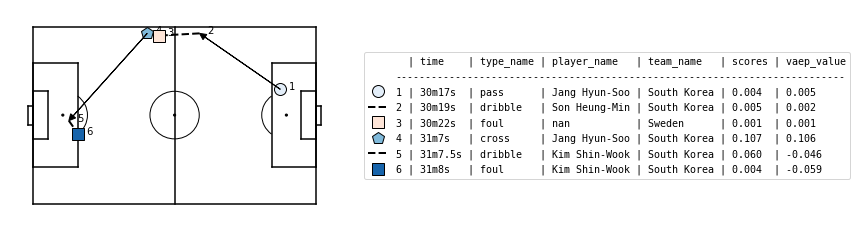

2018-06-27 16:00:00 South Korea 2-0 Germany 54' cross Yong Lee


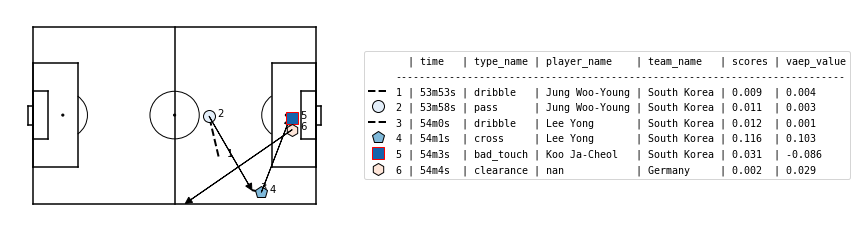

In [24]:
import matplotsoccer

team_name = "South Korea"
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == team_name] # view only actions from the team
# sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] # eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A.loc[i-3:i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
    
    g = games[games.game_id == a.game_id.values[0]].iloc[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id", "time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x", "start_y", "end_x", "end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)